# Kindle data: data pre-processing
---

We are using Amazon Kindle review data, the source of which can be found <a href='https://nijianmo.github.io/amazon/index.html'>here</a>.

Before inputting our data straight into any neural network, it is important to get a grasp of the raw data and make any necessary amendments.

In [1]:
# imports
import pandas as pd
import gzip
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# scraping data from online repository

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

### The below cell takes a VERY long time to run, since we are scraping the (very large) dataset from the online source.

In [3]:
df = getDF('Kindle_Store_5.json.gz')

In [4]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4.0,True,"07 3, 2014",A2LSKD2H9U8N0J,B000FA5KK0,{'Format:': ' Kindle Edition'},sandra sue marsolek,"pretty good story, a little exaggerated, but I...",pretty good story,1404345600,NaN,NaN
1,5.0,True,"05 26, 2014",A2QP13XTJND1QS,B000FA5KK0,{'Format:': ' Kindle Edition'},Tpl,"If you've read other max brand westerns, you k...",A very good book,1401062400,NaN,NaN
2,5.0,True,"09 16, 2016",A8WQ7MAG3HFOZ,B000FA5KK0,{'Format:': ' Kindle Edition'},Alverne F. Anderson,"Love Max, always a fun twist",Five Stars,1473984000,NaN,NaN
3,5.0,True,"03 3, 2016",A1E0MODSRYP7O,B000FA5KK0,{'Format:': ' Kindle Edition'},Jeff,"As usual for him, a good book",a good,1456963200,NaN,NaN
4,5.0,True,"09 10, 2015",AYUTCGVSM1H7T,B000FA5KK0,{'Format:': ' Kindle Edition'},DEHS - EddyRapcon,MB is one of the original western writers and ...,A Western,1441843200,2,NaN


In [5]:
df.describe()

,overall,unixReviewTime
count,2.222983e+06,2.222983e+06
mean,4.394687e+00,1.433041e+09
std,9.260669e-01,4.430677e+07
min,1.000000e+00,8.820576e+08
25%,4.000000e+00,1.404778e+09
50%,5.000000e+00,1.434672e+09
75%,5.000000e+00,1.462234e+09
max,5.000000e+00,1.538525e+09


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2222983 entries, 0 to 2222982
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   overall         float64
 1   verified        bool   
 2   reviewTime      object 
 3   reviewerID      object 
 4   asin            object 
 5   style           object 
 6   reviewerName    object 
 7   reviewText      object 
 8   summary         object 
 9   unixReviewTime  int64  
 10  vote            object 
 11  image           object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 205.6+ MB


We begin by removing any unverified reviews and removing unnecessary columns:

In [7]:
# cleaning up the dataset

# only include verified reviews
df_new = df[df["verified"] == True]

In [8]:
# removing unnecessary columns
df_new = df_new[["overall", "reviewTime", "reviewText", "summary"]]

In [9]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1418037 entries, 0 to 2222982
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   overall     1418037 non-null  float64
 1   reviewTime  1418037 non-null  object 
 2   reviewText  1417696 non-null  object 
 3   summary     1417127 non-null  object 
dtypes: float64(1), object(3)
memory usage: 54.1+ MB


In [10]:
df_new.head()

,overall,reviewTime,reviewText,summary
0,4.0,"07 3, 2014","pretty good story, a little exaggerated, but I...",pretty good story
1,5.0,"05 26, 2014","If you've read other max brand westerns, you k...",A very good book
2,5.0,"09 16, 2016","Love Max, always a fun twist",Five Stars
3,5.0,"03 3, 2016","As usual for him, a good book",a good
4,5.0,"09 10, 2015",MB is one of the original western writers and ...,A Western


## 5-category classification problem

In [11]:
df_new = df_new.sort_values('overall')

df_new.head()

,overall,reviewTime,reviewText,summary
1835207,1.0,"06 16, 2016","This is terrible and, sadly, could have been g...",Tripe
2167108,1.0,"03 14, 2016",The whole diary thing didn't work at all. It ...,Stupid idea
943273,1.0,"03 20, 2017",This is a free short story on Amazon. It's fil...,Not for me
2167105,1.0,"10 28, 2016",Free at least! That's the best part about this...,Considering it is free.
2167103,1.0,"01 10, 2018",A waste of time should have started woth the s...,Dont waste your time


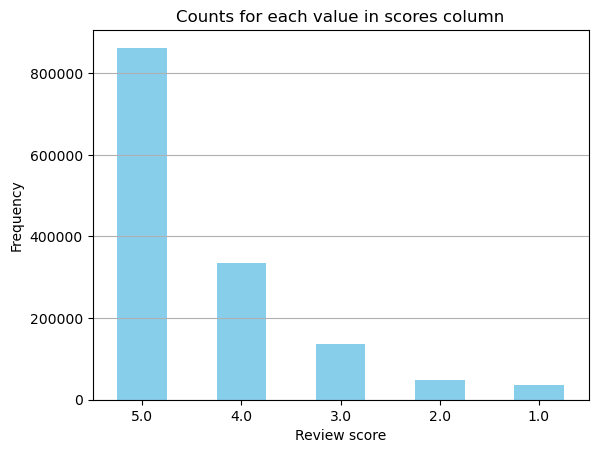

In [12]:
value_counts = df_new['overall'].value_counts()

# Plotting bar chart of counts for each value in 'Category' column
#plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Counts for each value in scores column')
plt.xlabel('Review score')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Rotate x labels if needed
plt.grid(axis='y')
plt.show()

An imbalanced dataset will make it extremely difficult for our resultant model to learn properly. We utilise undersampling to mitigate the problem:

In [20]:
# Calculate the minimum count among the different score values
min_count = df_new['overall'].value_counts().min()

# Undersample each score value to have the same count as the minimum count
balanced_df = pd.concat([
    df_new[df_new['overall'] == score].sample(min_count) for score in df_new['overall'].unique()
])

# Shuffle the balanced DataFrame
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

In [21]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181465 entries, 0 to 181464
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     181465 non-null  float64
 1   reviewTime  181465 non-null  object 
 2   reviewText  181433 non-null  object 
 3   summary     181383 non-null  object 
dtypes: float64(1), object(3)
memory usage: 5.5+ MB


In [22]:
balanced_df.head()

,overall,reviewTime,reviewText,summary
0,3.0,"05 1, 2015",Si bien es entretenido y una lectura f&aacute;...,Poco original
1,4.0,"10 23, 2015",Love Mary Calmes and love this series.,Four Stars
2,2.0,"03 11, 2015",I am a huge Charlie Richards fan. I have read ...,I guess I am spoiled...
3,3.0,"03 22, 2016",I was captivated by the characters in this nov...,Interesting read
4,3.0,"10 27, 2013","Not bad, but way too sweet for me, it needed a...",Sweet


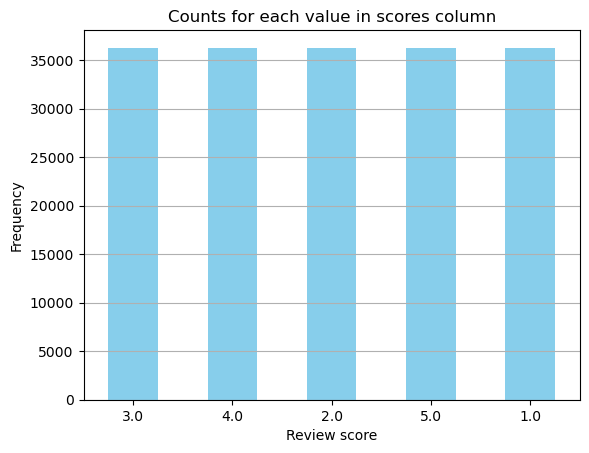

In [23]:
value_counts_balanced = balanced_df['overall'].value_counts()

# Plotting bar chart of counts for each value in 'Category' column
# plt.figure(figsize=(8, 6))
value_counts_balanced.plot(kind='bar', color='skyblue')
plt.title('Counts for each value in scores column')
plt.xlabel('Review score')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Rotate x labels if needed
plt.grid(axis='y')
plt.show()

In [24]:
balanced_df = balanced_df.sort_values('overall')

balanced_df.head()

,overall,reviewTime,reviewText,summary
136024,1.0,"08 21, 2015",Good grief! Do cops really act like this. All ...,I think I've gained ten pounds!
114503,1.0,"08 2, 2014",Bad. Just bad.,Don't waste your time
114505,1.0,"01 22, 2018",Message to author: the write up on your book ...,Forget it
67052,1.0,"05 16, 2015",Single-handedly the worst book I have ever rea...,Slow read. Torture. Pure torture.
114511,1.0,"02 14, 2015",Not my type of book.,One Star


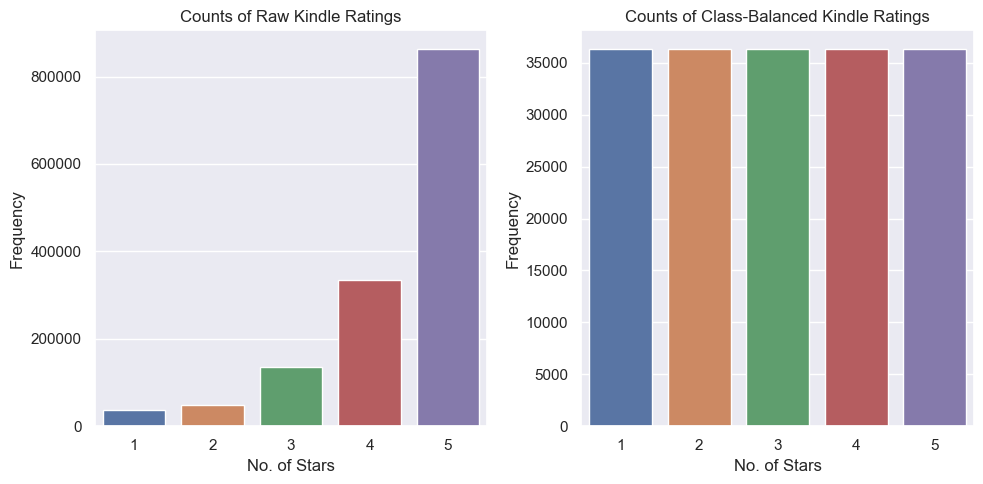

In [37]:
# convert floats to integers
df_new['overall'] = df_new['overall'].astype(int)
balanced_df['overall'] = balanced_df['overall'].astype(int)

# countplots side by side
sns.set()
fig, ax =plt.subplots(1,2, figsize=((10,5)))
sns.countplot(data=df_new, x='overall', ax=ax[0])
sns.countplot(data=balanced_df, x='overall', ax=ax[1])

ax[0].set_title('Counts of Raw Kindle Ratings')
ax[0].set_xlabel('No. of Stars')
ax[0].set_ylabel('Frequency')
ax[1].set_title('Counts of Class-Balanced Kindle Ratings')
ax[1].set_xlabel('No. of Stars')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [19]:
balanced_df.to_csv("kindle_balanced.csv", index=False)

## 3-category classification problem

A simplified version of our original problem involves grouping the review scores into 'Positive', 'Negative' and 'Neutral' sentiment. That is, we group together the 4 and 5 star reviews for positive, 1 and 2 star reviews for negative and relabel 3 start reviews as neutral.

In [20]:
# df_one = df_new[df_new['overall'] == 1]
# df_two = df_new[df_new['overall'] == 2]
# df_three = df_new[df_new['overall'] == 3]
# df_four = df_new[df_new['overall'] == 4]
# df_five = df_new[df_new['overall'] == 5]

In [33]:
df_sent = df_new.copy()

In [34]:
scores_to_sentiment = {1:'Negative', 2:'Negative', 3:'Neutral', 4:'Positive', 5:'Positive'}

# replace scores with sentiment labels
df_sent['overall'] = df_sent['overall'].replace(scores_to_sentiment)

In [36]:
df_sent['overall'].value_counts()

overall
Positive    1197045
Neutral      135302
Negative      85690
Name: count, dtype: int64

In [39]:
df_sent.head()

,overall,reviewTime,reviewText,summary
0,Positive,"07 3, 2014","pretty good story, a little exaggerated, but I...",pretty good story
1,Positive,"05 26, 2014","If you've read other max brand westerns, you k...",A very good book
2,Positive,"09 16, 2016","Love Max, always a fun twist",Five Stars
3,Positive,"03 3, 2016","As usual for him, a good book",a good
4,Positive,"09 10, 2015",MB is one of the original western writers and ...,A Western


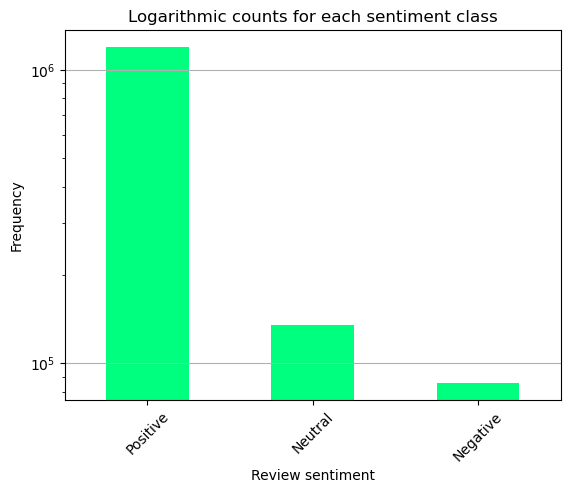

In [65]:
df_sent['overall'].value_counts().plot(kind='bar', color='springgreen')
plt.title('Logarithmic counts for each sentiment class')
plt.xlabel('Review sentiment')
plt.ylabel('Frequency')
plt.yscale('log')
plt.xticks(rotation=45)  # Rotate x labels if needed
plt.grid(axis='y')
plt.show()

In [45]:
# Calculate the minimum count among the different score values
min_count_sent = df_sent['overall'].value_counts().min()

# Undersample each score value to have the same count as the minimum count
balanced_df_sent = pd.concat([
    df_sent[df_sent['overall'] == score].sample(min_count_sent) for score in df_sent['overall'].unique()
])

# Shuffle the balanced DataFrame
balanced_df_sent = balanced_df_sent.sample(frac=1).reset_index(drop=True)

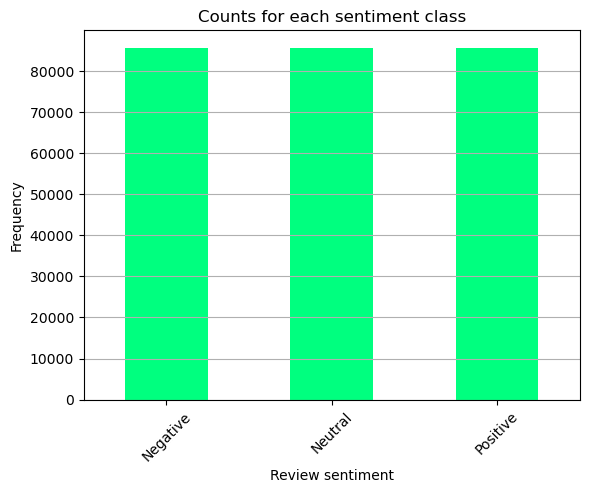

In [66]:
balanced_df_sent['overall'].value_counts().plot(kind='bar', color='springgreen')
plt.title('Counts for each sentiment class')
plt.xlabel('Review sentiment')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x labels if needed
plt.grid(axis='y')
plt.show()

In [54]:
balanced_df_sent.to_csv('three_class_balanced.csv', index=False)

### Preparing data for binary classification
---
Finally, we create the class-balanced dataset containing just positive and negative reviews, i.e. we just remove the neutral sentiment reviews from the previous dataset.

In [2]:
df_final = pd.read_csv('three_class_balanced.csv')

In [3]:
df_final.head()

,overall,reviewTime,reviewText,summary
0,Negative,"11 12, 2013",I could not read the entire story. The book wa...,nope
1,Neutral,"10 7, 2014",This was a sweet read.....i recommend if your ...,A sweet read.
2,Positive,"09 9, 2013",Greetings from Australia. A brilliant story. W...,Brilliant
3,Positive,"01 25, 2014",My first book from this author and I really li...,Beautiful
4,Positive,"02 24, 2016","Dark City is quite a dark novel, chilling and ...","Dark thriller, worth reading."


In [4]:
# filter out neutral-sentiment reviews
df_final = df_final[df_final['overall'] != 'Neutral']

In [5]:
df_final['overall'].value_counts()

overall
Negative    85690
Positive    85690
Name: count, dtype: int64

In [7]:
df_final.to_csv('binary_class_balanced.csv', index=False)